In [3]:
import os
import sys

import xarray as xr
import numpy as np
import cv2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap

# Get the current working directory
CURRENT_DIR = os.getcwd()

# Set the root directory to the parent of the current directory
ROOT = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
sys.path.insert(0, ROOT)

from code_.tools.loading import load_nsd_images
from code_.encoding_score.benchmarks.nsd import filter_activations, load_nsd_data
from code_.model_activations.loading import load_full_identifier

from config import RESULTS, FIGURES, CACHE



# tSNE

In [4]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

# Ensure required packages are installed: pip install umap-learn opencv-python matplotlib scikit-learn

def scale_to_01_range(x):
    """Scale values between 0 and 1."""
    value_range = np.max(x) - np.min(x)
    return (x - np.min(x)) / value_range if value_range != 0 else x

def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    """Compute image positions on the plot."""
    image_height, image_width, _ = image.shape
    center_x = int(image_centers_area_size * x) + offset
    center_y = int(image_centers_area_size * (1 - y)) + offset  # Mirror y-axis

    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

def scale_image(image, max_image_size):
    """Resize images while maintaining aspect ratio."""
    image_height, image_width, _ = image.shape
    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    return cv2.resize(image, (image_width, image_height))

def get_embeddings(data, method="UMAP"):
    """
    Perform dimensionality reduction (UMAP or t-SNE) and visualize images.
    
    Parameters:
    - data: (N, D) numpy array of feature vectors.
    - images: List of image paths corresponding to each data point.
    - name: Output filename.
    - method: Choose between "UMAP" and "tSNE".
    - dpi: Resolution of the output plot.
    - plot_size: Size of the final visualization.
    - max_image_size: Max image size on the plot.
    """

    # Perform dimensionality reduction
    if method.lower() == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(data)
    elif method.lower() == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embedding = reducer.fit_transform(data)
    else:
        raise ValueError("Invalid method! Choose 'UMAP' or 'tSNE'.")

    return embedding
    

def visualize_embeddings(embedding, images, save_path,  method, dpi=300, plot_size=1000, max_image_size=50):
    # Normalize the reduced output to [0,1] range
    tx = scale_to_01_range(embedding[:, 0])
    ty = scale_to_01_range(embedding[:, 1])

    # Set up the visualization plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset
    plot_canvas = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # Place images on the scatter plot
    for i in range(len(images)):
        x, y = tx[i], ty[i]
        try:
            image = cv2.imread(images[i])
            image = scale_image(image, max_image_size)
            tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
            plot_canvas[tl_y:br_y, tl_x:br_x, :] = image  # Place image on plot
        except AttributeError:
            pass  # Ignore images that fail to load

    # Plot and save figure
    fig = plt.figure(figsize=(80, 50), dpi=300)
    plt.imshow(plot_canvas[:, :, ::-1])
    plt.axis("off")
    plt.title(f"{method} Visualization", fontsize=50)
    plt.savefig(save_path, dpi=dpi)
    plt.show()

In [5]:
# load model activations
CACHE = '/data/atlas/.repo_cache_10'
identifier = load_full_identifier(model_name='expansion', features=3, layers=5, dataset='naturalscenes')
features = xr.open_dataarray(os.path.join(CACHE,'activations',identifier),engine='netcdf4')

# load images seen by subject 1
subject = 1
IDS = load_nsd_data(mode='unshared', subject=subject, region='early visual stream')[0]
images  = [image for image in load_nsd_images() if os.path.basename(image).strip('.png') in IDS]

# filter activations for images seen by subject 1
features = filter_activations(features, IDS)

# tsne_ints = TSNE(n_components=2).fit_transform(features)
# tx = tsne_ints[:, 0]
# ty = tsne_ints[:, 1]
# tx = scale_to_01_range(tx)
# ty = scale_to_01_range(ty)
# dpi  = 800
# # visualize 
# visualize_tsne_images(tx, ty, images, 
#                       dpi = dpi, 
#                       plot_size=1000, 
#                       max_image_size=10)

In [4]:
# plot umap or tsne
method = 'tsne'
save_path = os.path.join(FIGURES, f'{method.lower()}- subject={subject}.png')
embedding = get_embeddings(features, method)

In [8]:
from code_.model_activations.configs import model_cfg as cfg
from code_.encoding_score.rsa import DIST, RSA, RDM
from tqdm import tqdm
import os
from tqdm import tqdm 

from code_.encoding_score.benchmarks.majajhong import load_majaj_data, load_activations
from code_.encoding_score.benchmarks.nsd import load_nsd_data, filter_activations

from config import CACHE

rsa_dict = {}
model_name = 'expansion'
dataset = 'majajhong'
print(f'computing RSA for model: {model_name}')
rsa_dict[model_name] = []
model_idens = []
SUBJECTS = ['Chabo','Tito']
region = 'IT'
metric = 'pearsonr'

for features in cfg[dataset]['models'][model_name]['features']:

    print(features)
    # load model activations
    identifier = load_full_identifier(model_name='expansion', features=features, layers=5, dataset=dataset)
    features = load_activations(activations_identifier=identifier, mode='all')
    activations = get_embeddings(features, 'tsne')
    
    rdm = RDM()
    rsa = RSA(metric=metric)
    
    rsa_all = []
    for subject in tqdm(SUBJECTS):
        # Compute RDM for neural data once, since it doesn't change across features
        neural_data = load_majaj_data(mode= 'all', subject = subject, region= region)
        RDM_neural = rdm(neural_data)
    
        # Compute the RDM for the activations
        RDM_expansion = rdm(activations)
        
        # Compute the similarity between neural RDM and activations RDM
        rsa_ = rsa(RDM_neural, RDM_expansion)
        rsa_all.append(rsa_)

    rsa_dict[model_name].append(sum(rsa_all)/len(rsa_all)) 
 

computing RSA for model: expansion
3
/data/atlas/.repo_cache_10 expansion_features=3_layers=5_dataset=majajhong


100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


30
/data/atlas/.repo_cache_10 expansion_features=30_layers=5_dataset=majajhong


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


300
/data/atlas/.repo_cache_10 expansion_features=300_layers=5_dataset=majajhong


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


3000
/data/atlas/.repo_cache_10 expansion_features=3000_layers=5_dataset=majajhong


100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


30000
/data/atlas/.repo_cache_10 expansion_features=30000_layers=5_dataset=majajhong


100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


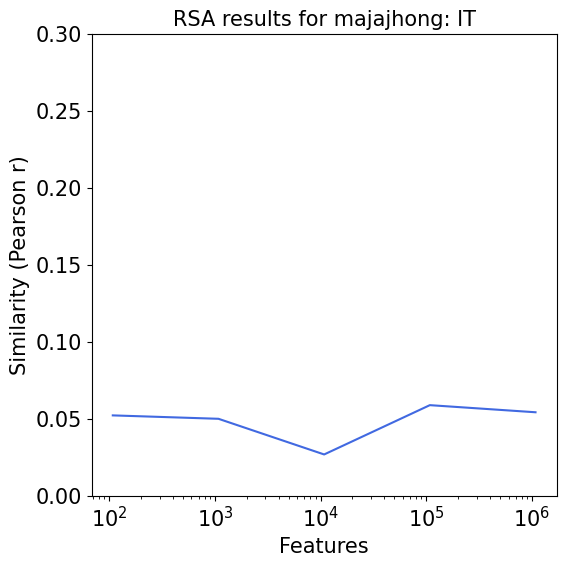

In [9]:
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
# from notebooks.plotting_tools import *

rcParams['figure.figsize'] = (6,6)  
legend_dict ={'expansion':('Convolutional','royalblue'),
        'vit':('Transformer','palevioletred'),
        'fully_connected':('Fully connected','darkviolet')}

# main plot
for model_name in ['expansion']:
    features = cfg[dataset]['models'][model_name]['features']
    if model_name == 'expansion':
        features = [f*36 for f in features] 
    elif model_name == 'vit':
        features = [f*196 for f in features] 
    else:
        pass
    
    ax1 = sns.lineplot(x=features, 
                       y=rsa_dict[model_name], 
                       c=legend_dict[model_name][1], 
                       label=legend_dict[model_name][0])
# alexnet 
# plt.axhline(y=rsa_alexnet, color='gray', linestyle='--', label='AlexNet')

plt.xlabel('Features',size=15)
plt.ylabel('Similarity (Pearson r)',size=15)
plt.ylim(0,0.3) if dataset == 'naturalscenes' else plt.ylim(0,0.3)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title(f'RSA results for {dataset}: {region}',size=15)
ax1.set_xscale("log")    
if region != 'V4':
    ax1.legend()
    ax1.get_legend().remove()
plt.savefig(os.path.join(FIGURES, f'figure_S2_{dataset}_{region}.png'))
plt.show()

In [2]:
visualize_embeddings(embedding, images, save_path,  method, max_image_size=10)

NameError: name 'visualize_embeddings' is not defined